# Time Series Forecasting with TensorFlow

### Contents of this notebook
  * Get the time series data
    * Load the time series data using Pandas/Python,s CSV module
  * Format data for a time series problem
    * Creating training and test sets (the wrong way)
    * Creating training and test sets (the right way)
    * Visualizing time series data
    * Turning time series data into a supervised learning problem (windowing)
    * Preparing univariate and multivariate
  * Evaluating a time series forecasting model
  * Setting up a series of deep learning modelling experiments
    * Dense (fully-connected) networks
    * Sequence models (LSTM and 1D CNN)
    * Ensembling (combining multiple models together)
    * Multivariate models
    * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
  * Creating a model checkpoint to save the best performing model during training
  * Making predictions (forecasts) with a time series model
  * Creating prediction intervals for the time series model forecasts
  * Discussing two different types of uncertainity in machine learning (data uncertainity and model uncertainity)
  * Demonstrating why forecasting in an open system is BS (the turkey problem)

### Check for GPU

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d9ea2554-d9c2-b958-dfa3-144f9247e399)


## Get data

In [2]:
# Download Bitcoin historical data from GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-02-27 17:53:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.003s  

2023-02-27 17:53:28 (61.6 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas

In [3]:
# Import with pandas
import pandas as pd
import numpy as np
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

In [4]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
df.shape

(2787, 5)

In [7]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


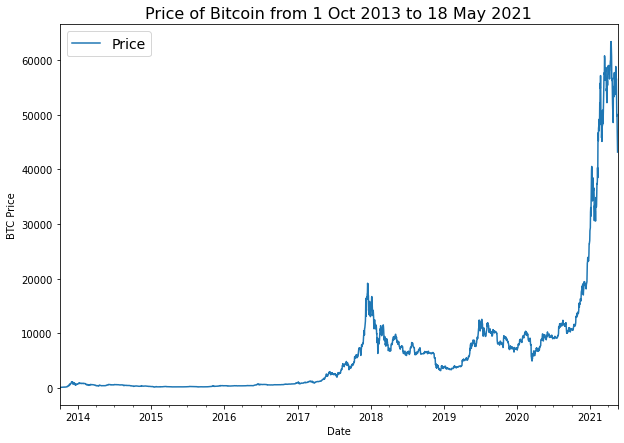

In [8]:
# Visulaizing data
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

In [9]:
# Importing and formatting historical Bitcoin data with Python

import csv
from datetime import datetime

timesteps = []
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv') as f:
  csv_reader = csv.reader(f, delimiter=',')
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# View first 10 of each

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

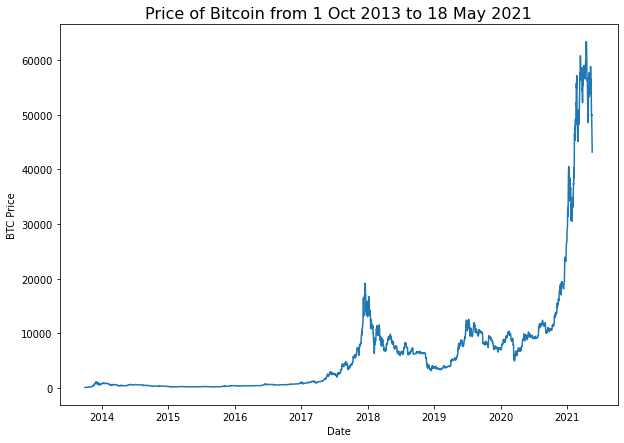

In [10]:
# Plot from CSV
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.xlabel('Date')

## Formatting data for time series problem

### Creating train and test sets for time series data (the wrong way)

In [11]:
# Get Bitcoin date array

timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Wrong way to make train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

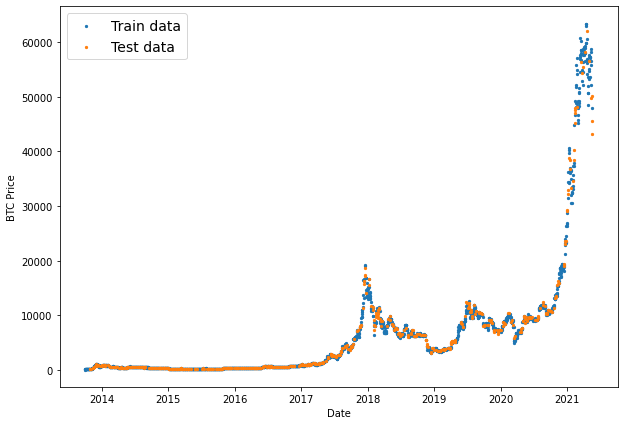

In [13]:
# Plotting wrong train and test splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating train and test sets for time series data (the right way)

In [14]:
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[0:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

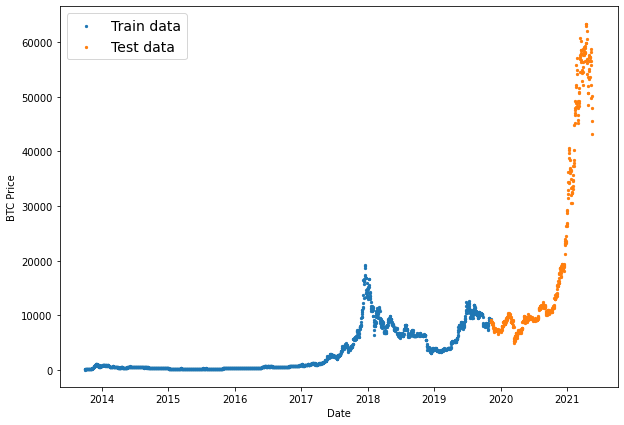

In [15]:
# Plot correctly made splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating a plotting function

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True) 

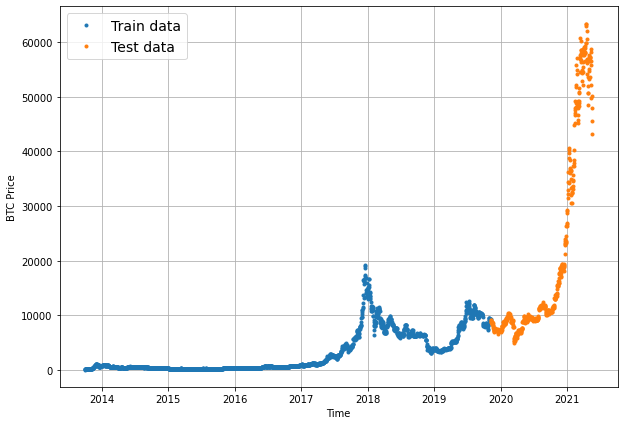

In [17]:
# Try out our plotting function

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

## Modelling Experiments

### Model 0: Naive Forecast (baseline)

In [18]:
# Create a naive forecast

naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

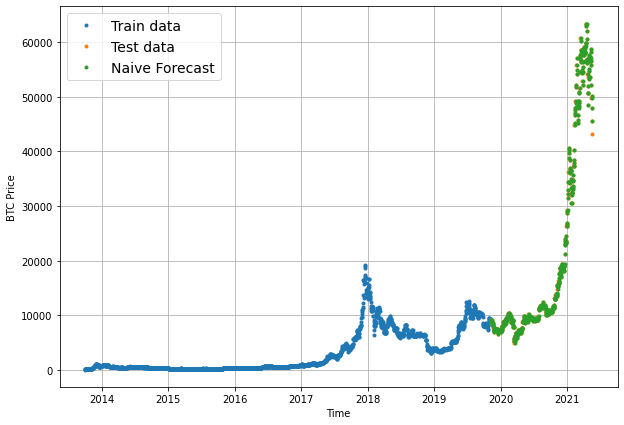

In [19]:
# Plot naive forecast

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, label='Naive Forecast')

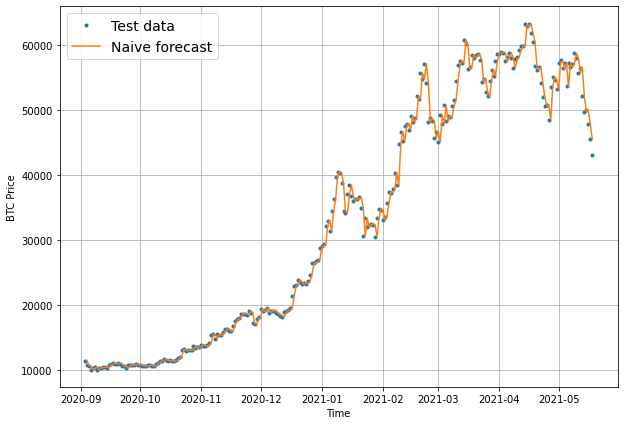

In [20]:
# Zooming in the plot

plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format='-', label='Naive forecast')


### Evaluating a time series model

In [21]:
import tensorflow as tf

In [22]:
# Create a function to calculate MASE (mean absolute scaled error)

def mean_absolute_scaled_error(y_true, y_pred):
  
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  
  return mae/mae_naive_no_season

In [23]:
# Create a function to calculate results (predictions)

def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Other models/libraries for time series forecasting
  * Moving average
  * ARIMA (AutoRegression Integrated Moving Average)
  * Sktime (Scikit-learn for time series)
  * TensorFlow Decision Forecasts (random forest, gradient boosting trees)
  * Facebook Kats (purpose built forecasting and time series analysis library by facebook)
  * LinkedIn Greykite (flexible, intuitive and fast forecasts)


### Windowing dataset

In [25]:
HORIZON = 1           # Predict 1 step at a time
WINDOW_SIZE = 7       # Use a week worth of timestamps to predict the horizon

In [26]:
# Create a function to label windowed data

def get_labelled_windows(x, horizon=1):

  return x[:,:-horizon], x[:,-horizon:]

In [27]:
# Test out the window labelling function

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {test_window} -> Label: {test_label}")

Window: [[1 2 3 4 5 6 7]] -> Label: [[8]]


In [28]:
# Create a function to view NumPy arrays as windows

def make_windows(x, window_size=7, horizon=1):

  # 1. Create a window of specific window size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for zero indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [30]:
# View the first three windows/labels

for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


### Turning windows into training and test sets

In [31]:
# Make the train test split

def make_train_test_split(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [33]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Make modelling checkpoint

In [34]:
import os

# Create a function ti implement model checkpoint callback with a specific filename

def create_model_checkpoint(model_name, save_path="model_experiments"):
  
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

### Model 1: Dense model (window = 7, horizon = 1)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers

# Set seed
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 2815.2039 - mae: 2815.2039

18/18 [==============================] - 8s 97ms/step - loss: 2815.2039 - mae: 2815.2039 - val_loss: 5023.9062 - val_mae: 5023.9062
Epoch 2/100
11/18 [=================>............] - ETA: 0s - loss: 451.8616 - mae: 451.8616

18/18 [==============================] - 1s 60ms/step - loss: 412.0780 - mae: 412.0780 - val_loss: 1242.4548 - val_mae: 1242.4548
Epoch 3/100
15/18 [========================>.....] - ETA: 0s - loss: 227.5244 - mae: 227.5244

18/18 [==============================] - 1s 88ms/step - loss: 222.3726 - mae: 222.3726 - val_loss: 989.8345 - val_mae: 989.8345
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 177.7150 - mae: 177.7150

18/18 [==============================] - 1s 73ms/step - loss: 177.7150 - mae: 177.7150 - val_loss: 953.3420 - val_mae: 953.3420
Epoch 5/100
18/18 [==============================] - 0s 14ms/step - loss: 172.6308 - mae: 172.6308 - val_loss: 986.1180 - val_mae: 986.1180
Epoch 6/100
15/18 [========================>.....] - ETA: 0s - loss: 167.6015 - mae: 167.6015

18/18 [==============================] - 1s 49ms/step - loss: 167.1591 - mae: 167.1591 - val_loss: 913.3704 - val_mae: 913.3704
Epoch 7/100
14/18 [======================>.......] - ETA: 0s - loss: 168.6122 - mae: 168.6122

18/18 [==============================] - 1s 55ms/step - loss: 162.0413 - mae: 162.0413 - val_loss: 908.6212 - val_mae: 908.6212
Epoch 8/100
14/18 [======================>.......] - ETA: 0s - loss: 156.2281 - mae: 156.2281

18/18 [==============================] - 1s 59ms/step - loss: 158.1908 - mae: 158.1908 - val_loss: 868.6873 - val_mae: 868.6873
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 156.4045 - mae: 156.4045 - val_loss: 898.8521 - val_mae: 898.8521
Epoch 10/100
14/18 [======================>.......] - ETA: 0s - loss: 148.7298 - mae: 148.7298

18/18 [==============================] - 1s 49ms/step - loss: 152.1206 - mae: 152.1206 - val_loss: 826.8824 - val_mae: 826.8824
Epoch 11/100
14/18 [======================>.......] - ETA: 0s - loss: 151.4177 - mae: 151.4177

18/18 [==============================] - 1s 49ms/step - loss: 149.1620 - mae: 149.1620 - val_loss: 818.5511 - val_mae: 818.5511
Epoch 12/100
18/18 [==============================] - 0s 15ms/step - loss: 145.7330 - mae: 145.7330 - val_loss: 856.8476 - val_mae: 856.8476
Epoch 13/100
18/18 [==============================] - 0s 17ms/step - loss: 145.7786 - mae: 145.7786 - val_loss: 831.8348 - val_mae: 831.8348
Epoch 14/100
18/18 [==============================] - 0s 8ms/step - loss: 143.2645 - mae: 143.2645 - val_loss: 824.0334 - val_mae: 824.0334
Epoch 15/100
13/18 [====================>.........] - ETA: 0s - loss: 138.2464 - mae: 138.2464

18/18 [==============================] - 1s 53ms/step - loss: 141.4447 - mae: 141.4447 - val_loss: 771.6739 - val_mae: 771.6739
Epoch 16/100
18/18 [==============================] - 0s 14ms/step - loss: 137.6863 - mae: 137.6863 - val_loss: 776.9847 - val_mae: 776.9847
Epoch 17/100
11/18 [=================>............] - ETA: 0s - loss: 141.6174 - mae: 141.6174

18/18 [==============================] - 1s 83ms/step - loss: 137.0860 - mae: 137.0860 - val_loss: 766.9623 - val_mae: 766.9623
Epoch 18/100
11/18 [=================>............] - ETA: 0s - loss: 141.4730 - mae: 141.4730

18/18 [==============================] - 1s 72ms/step - loss: 135.3879 - mae: 135.3879 - val_loss: 743.2287 - val_mae: 743.2288
Epoch 19/100
18/18 [==============================] - 0s 12ms/step - loss: 132.9140 - mae: 132.9140 - val_loss: 756.2451 - val_mae: 756.2451
Epoch 20/100
18/18 [==============================] - ETA: 0s - loss: 131.5996 - mae: 131.5996

18/18 [==============================] - 2s 95ms/step - loss: 131.5996 - mae: 131.5996 - val_loss: 723.3439 - val_mae: 723.3439
Epoch 21/100
11/18 [=================>............] - ETA: 0s - loss: 139.9231 - mae: 139.9231

18/18 [==============================] - 1s 69ms/step - loss: 133.7613 - mae: 133.7613 - val_loss: 712.2277 - val_mae: 712.2277
Epoch 22/100
10/18 [===============>..............] - ETA: 0s - loss: 147.0316 - mae: 147.0316

18/18 [==============================] - 1s 51ms/step - loss: 129.9877 - mae: 129.9877 - val_loss: 707.2269 - val_mae: 707.2269
Epoch 23/100
13/18 [====================>.........] - ETA: 0s - loss: 125.5167 - mae: 125.5167

18/18 [==============================] - 1s 56ms/step - loss: 128.3354 - mae: 128.3354 - val_loss: 699.8143 - val_mae: 699.8143
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 140.1850 - mae: 140.1850

18/18 [==============================] - 1s 48ms/step - loss: 127.1128 - mae: 127.1128 - val_loss: 692.4988 - val_mae: 692.4988
Epoch 25/100
13/18 [====================>.........] - ETA: 0s - loss: 130.1964 - mae: 130.1964

18/18 [==============================] - 1s 42ms/step - loss: 126.1517 - mae: 126.1517 - val_loss: 683.5342 - val_mae: 683.5342
Epoch 26/100
10/18 [===============>..............] - ETA: 0s - loss: 131.2235 - mae: 131.2235

18/18 [==============================] - 1s 52ms/step - loss: 127.5738 - mae: 127.5738 - val_loss: 675.4610 - val_mae: 675.4610
Epoch 27/100
13/18 [====================>.........] - ETA: 0s - loss: 130.7423 - mae: 130.7423

18/18 [==============================] - 2s 99ms/step - loss: 127.5380 - mae: 127.5380 - val_loss: 671.1588 - val_mae: 671.1588
Epoch 28/100
16/18 [=========================>....] - ETA: 0s - loss: 122.3230 - mae: 122.3230

18/18 [==============================] - 2s 124ms/step - loss: 122.9969 - mae: 122.9969 - val_loss: 667.0850 - val_mae: 667.0850
Epoch 29/100
18/18 [==============================] - 0s 8ms/step - loss: 121.6022 - mae: 121.6022 - val_loss: 669.2619 - val_mae: 669.2619
Epoch 30/100
18/18 [==============================] - 0s 11ms/step - loss: 130.2344 - mae: 130.2344 - val_loss: 728.9180 - val_mae: 728.9180
Epoch 31/100
18/18 [==============================] - 0s 7ms/step - loss: 143.1132 - mae: 143.1132 - val_loss: 990.2930 - val_mae: 990.2930
Epoch 32/100
16/18 [=========================>....] - ETA: 0s - loss: 141.2855 - mae: 141.2855

18/18 [==============================] - 1s 50ms/step - loss: 141.9871 - mae: 141.9871 - val_loss: 658.4121 - val_mae: 658.4121
Epoch 33/100
18/18 [==============================] - 0s 11ms/step - loss: 124.2080 - mae: 124.2080 - val_loss: 675.6932 - val_mae: 675.6932
Epoch 34/100
10/18 [===============>..............] - ETA: 0s - loss: 126.1730 - mae: 126.1730

18/18 [==============================] - 2s 97ms/step - loss: 122.9536 - mae: 122.9536 - val_loss: 649.0237 - val_mae: 649.0237
Epoch 35/100
18/18 [==============================] - 0s 14ms/step - loss: 121.5699 - mae: 121.5699 - val_loss: 657.4247 - val_mae: 657.4247
Epoch 36/100
18/18 [==============================] - 0s 13ms/step - loss: 128.4448 - mae: 128.4448 - val_loss: 750.2635 - val_mae: 750.2635
Epoch 37/100
10/18 [===============>..............] - ETA: 0s - loss: 116.0188 - mae: 116.0188

18/18 [==============================] - 1s 50ms/step - loss: 122.4800 - mae: 122.4800 - val_loss: 639.4223 - val_mae: 639.4223
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 107.6847 - mae: 107.6847

18/18 [==============================] - 1s 61ms/step - loss: 118.5309 - mae: 118.5309 - val_loss: 631.7832 - val_mae: 631.7832
Epoch 39/100
18/18 [==============================] - 0s 4ms/step - loss: 117.2918 - mae: 117.2918 - val_loss: 644.0508 - val_mae: 644.0508
Epoch 40/100
18/18 [==============================] - 0s 9ms/step - loss: 117.2873 - mae: 117.2873 - val_loss: 636.6291 - val_mae: 636.6291
Epoch 41/100
18/18 [==============================] - 0s 10ms/step - loss: 118.4627 - mae: 118.4627 - val_loss: 658.1978 - val_mae: 658.1978
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 114.5660 - mae: 114.5660

18/18 [==============================] - 1s 40ms/step - loss: 122.4966 - mae: 122.4966 - val_loss: 627.2758 - val_mae: 627.2758
Epoch 43/100
18/18 [==============================] - 0s 4ms/step - loss: 114.7376 - mae: 114.7376 - val_loss: 661.2139 - val_mae: 661.2139
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 75.9482 - mae: 75.9482

18/18 [==============================] - 1s 42ms/step - loss: 117.6938 - mae: 117.6938 - val_loss: 619.3602 - val_mae: 619.3602
Epoch 45/100
15/18 [========================>.....] - ETA: 0s - loss: 114.6775 - mae: 114.6775

18/18 [==============================] - 1s 37ms/step - loss: 116.3274 - mae: 116.3274 - val_loss: 614.9143 - val_mae: 614.9143
Epoch 46/100
13/18 [====================>.........] - ETA: 0s - loss: 119.0457 - mae: 119.0457

18/18 [==============================] - 1s 37ms/step - loss: 115.9806 - mae: 115.9806 - val_loss: 613.6616 - val_mae: 613.6616
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 117.3641 - mae: 117.3641 - val_loss: 681.7007 - val_mae: 681.7007
Epoch 48/100
18/18 [==============================] - 0s 8ms/step - loss: 114.2016 - mae: 114.2016 - val_loss: 627.0732 - val_mae: 627.0732
Epoch 49/100
18/18 [==============================] - 0s 4ms/step - loss: 114.2764 - mae: 114.2764 - val_loss: 653.5896 - val_mae: 653.5896
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 118.6535 - mae: 118.6535 - val_loss: 614.1885 - val_mae: 614.1885
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 114.1348 - mae: 114.1348 - val_loss: 620.8785 - val_mae: 620.8785
Epoch 52/100
14/18 [======================>.......] - ETA: 0s - loss: 120.7172 - mae: 120.7172

18/18 [==============================] - 1s 49ms/step - loss: 115.8306 - mae: 115.8306 - val_loss: 611.7498 - val_mae: 611.7498
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 116.3666 - mae: 116.3666 - val_loss: 632.4432 - val_mae: 632.4432
Epoch 54/100
17/18 [===========================>..] - ETA: 0s - loss: 114.5212 - mae: 114.5212

18/18 [==============================] - 1s 35ms/step - loss: 114.8185 - mae: 114.8185 - val_loss: 607.5453 - val_mae: 607.5453
Epoch 55/100
10/18 [===============>..............] - ETA: 0s - loss: 122.9631 - mae: 122.9631

18/18 [==============================] - 1s 45ms/step - loss: 115.9280 - mae: 115.9280 - val_loss: 599.5176 - val_mae: 599.5176
Epoch 56/100
18/18 [==============================] - 0s 9ms/step - loss: 112.3906 - mae: 112.3906 - val_loss: 829.4456 - val_mae: 829.4456
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 134.1783 - mae: 134.1783 - val_loss: 770.4379 - val_mae: 770.4379
Epoch 58/100
18/18 [==============================] - 0s 8ms/step - loss: 127.9778 - mae: 127.9778 - val_loss: 700.2397 - val_mae: 700.2397
Epoch 59/100
13/18 [====================>.........] - ETA: 0s - loss: 109.6180 - mae: 109.6180

18/18 [==============================] - 1s 52ms/step - loss: 111.7503 - mae: 111.7503 - val_loss: 595.9036 - val_mae: 595.9036
Epoch 60/100
18/18 [==============================] - 0s 7ms/step - loss: 111.3242 - mae: 111.3242 - val_loss: 603.5384 - val_mae: 603.5384
Epoch 61/100
18/18 [==============================] - 0s 9ms/step - loss: 109.9000 - mae: 109.9000 - val_loss: 600.0037 - val_mae: 600.0037
Epoch 62/100
16/18 [=========================>....] - ETA: 0s - loss: 112.3107 - mae: 112.3107

18/18 [==============================] - 1s 87ms/step - loss: 110.1556 - mae: 110.1556 - val_loss: 590.0572 - val_mae: 590.0572
Epoch 63/100
18/18 [==============================] - 0s 17ms/step - loss: 110.0991 - mae: 110.0991 - val_loss: 622.6064 - val_mae: 622.6064
Epoch 64/100
18/18 [==============================] - 0s 15ms/step - loss: 113.0103 - mae: 113.0103 - val_loss: 626.5792 - val_mae: 626.5792
Epoch 65/100
18/18 [==============================] - 0s 9ms/step - loss: 111.8464 - mae: 111.8464 - val_loss: 603.8076 - val_mae: 603.8076
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 110.6507 - mae: 110.6507 - val_loss: 594.8260 - val_mae: 594.8260
Epoch 67/100
18/18 [==============================] - 0s 12ms/step - loss: 110.6408 - mae: 110.6408 - val_loss: 679.9488 - val_mae: 679.9488
Epoch 68/100
18/18 [==============================] - 0s 19ms/step - loss: 111.3479 - mae: 111.3479 - val_loss: 602.1907 - val_mae: 602.1907
Epoch 69/100
18/18 [========

18/18 [==============================] - 1s 35ms/step - loss: 109.3342 - mae: 109.3342 - val_loss: 581.2332 - val_mae: 581.2332
Epoch 73/100
18/18 [==============================] - ETA: 0s - loss: 109.9516 - mae: 109.9516

18/18 [==============================] - 1s 50ms/step - loss: 109.9516 - mae: 109.9516 - val_loss: 580.6342 - val_mae: 580.6342
Epoch 74/100
18/18 [==============================] - 0s 10ms/step - loss: 112.7444 - mae: 112.7444 - val_loss: 581.7611 - val_mae: 581.7611
Epoch 75/100
18/18 [==============================] - 0s 4ms/step - loss: 109.2438 - mae: 109.2438 - val_loss: 594.2337 - val_mae: 594.2337
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 80.4474 - mae: 80.4474

18/18 [==============================] - 1s 36ms/step - loss: 110.3548 - mae: 110.3548 - val_loss: 579.9983 - val_mae: 579.9983
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 109.1913 - mae: 109.1913 - val_loss: 581.2756 - val_mae: 581.2756
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 110.8494 - mae: 110.8494 - val_loss: 595.2781 - val_mae: 595.2781
Epoch 79/100
12/18 [===================>..........] - ETA: 0s - loss: 107.8620 - mae: 107.8620

18/18 [==============================] - 1s 41ms/step - loss: 110.2224 - mae: 110.2224 - val_loss: 577.1467 - val_mae: 577.1467
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 108.7171 - mae: 108.7171 - val_loss: 582.7347 - val_mae: 582.7347
Epoch 81/100
18/18 [==============================] - 0s 8ms/step - loss: 107.0342 - mae: 107.0342 - val_loss: 582.9009 - val_mae: 582.9009
Epoch 82/100
13/18 [====================>.........] - ETA: 0s - loss: 120.5508 - mae: 120.5508

18/18 [==============================] - 1s 38ms/step - loss: 116.9127 - mae: 116.9127 - val_loss: 575.5626 - val_mae: 575.5626
Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 112.5295 - mae: 112.5295 - val_loss: 700.5540 - val_mae: 700.5540
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 116.5117 - mae: 116.5117 - val_loss: 628.4986 - val_mae: 628.4986
Epoch 85/100
18/18 [==============================] - 0s 10ms/step - loss: 109.3830 - mae: 109.3830 - val_loss: 592.9918 - val_mae: 592.9918
Epoch 86/100
18/18 [==============================] - 0s 9ms/step - loss: 108.6145 - mae: 108.6145 - val_loss: 587.8835 - val_mae: 587.8835
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 106.7637 - mae: 106.7637 - val_loss: 617.9603 - val_mae: 617.9603
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 109.3650 - mae: 109.3650 - val_loss: 600.1158 - val_mae: 600.1158
Epoch 89/100
18/18 [===========

In [36]:
# Evaluate model on test data

model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 6ms/step - loss: 698.6423 - mae: 698.6423


[698.6422729492188, 698.6422729492188]

In [37]:
# Load in saved best performing model_1 and evaluate on test data

model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 575.5626 - mae: 575.5626


[575.5625610351562, 575.5625610351562]

### Making forecast with model (on the test dataset)

In [38]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)

  return tf.squeeze(forecast)

In [39]:
# Make prediction using model_1 on the test dataset and view the results

model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8869.403, 8760.415, 8976.99 , 8783.485, 8723.836, 8727.06 ,
        8646.463, 8531.941, 8434.978, 8497.811], dtype=float32)>)

In [40]:
# Evaluate preds

model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 575.56256,
 'mse': 1199544.0,
 'rmse': 1095.2369,
 'mape': 2.5770702,
 'mase': 1.011104}

In [41]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

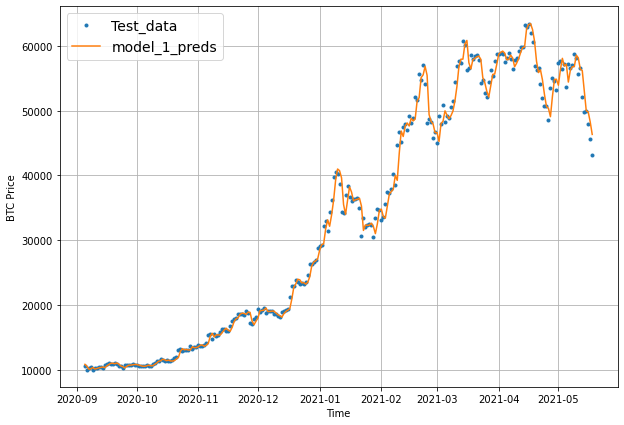

In [42]:
# Visualizing the result

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

In [43]:
HORIZON = 1
WINDOW_SIZE = 30

In [44]:
# Make windowed data with appropriate horizon nad window size

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [45]:
# Make train and test windows

train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows,
                                                                               labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [46]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [47]:
# Evaluate model_2 preds

model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 626.7998


626.7998046875

In [48]:
# Load in best performing model

model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 622.6226


622.62255859375

In [49]:
# Get forecast predictions

model_2_preds = make_preds(model_2,
                           input_data=test_windows)
model_2_preds[-10:]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([56153.926, 58268.79 , 58499.457, 56253.938, 56514.63 , 52775.266,
       51369.246, 49057.258, 47817.7  , 46591.883], dtype=float32)>

In [50]:
# Evaluate results for model_2 prediction

model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)

In [51]:
model_2_results

{'mae': 622.6226,
 'mse': 1280986.5,
 'rmse': 1131.8068,
 'mape': 2.839699,
 'mase': 1.0883504}

### Model 3: Dense (window = 30, horizon = 7)

In [52]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [53]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [54]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name = "model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [55]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 1431.2993


1431.29931640625

In [56]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1227.8115


1227.8115234375

In [57]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[-5:]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[57931.336, 57180.85 , 55788.137, 57520.38 , 56491.453, 57146.03 ,
        56997.055],
       [57816.812, 57661.27 , 56811.68 , 57709.973, 57291.324, 57107.383,
        57668.82 ],
       [58885.92 , 59003.605, 58033.047, 59114.46 , 58059.246, 57997.426,
        57623.55 ],
       [59320.754, 59953.76 , 57901.203, 59673.465, 58795.76 , 59706.45 ,
        58943.055],
       [58390.656, 57588.574, 55616.06 , 58102.223, 57285.605, 58853.31 ,
        58520.9  ]], dtype=float32)>

In [58]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  689.81726 ,   432.6557  ,   323.20074 ,   527.5971  ,
          527.6846  ,   493.82486 ,   429.93945 ,   543.285   ,
          525.4868  ,   720.7243  ,   884.5263  ,   800.7203  ,
          823.06006 ,   825.03253 ,   644.1453  ,   354.8496  ,
          215.57512 ,   203.08127 ,   211.73361 ,   196.5842  ,
          238.62166 ,   186.03195 ,   399.7468  ,   367.3635  ,
          212.62535 ,   140.45222 ,   138.07164 ,   108.96708 ,
          118.750694,   128.9774  ,   292.8265  ,   392.10318 ,
          360.94196 ,   329.9064  ,   296.77338 ,   282.11246 ,
          341.16705 ,   233.22824 ,   256.5645  ,   244.61433 ,
          391.62332 ,   107.218956,   121.82966 ,    85.79799 ,
          103.24505 ,   142.11496 ,    85.091934,   127.793594,
          104.53362 ,   116.99477 ,   111.885254,   186.68123 ,
          191.8074  ,   208.11398 ,   262.9687  ,   395.75845 ,
          497.637   ,   480.6919  ,   492.50433 ,   466.52463 ,
          395.24203 ,   197.70592

### Make our evaluation function work for larger horizon

In [59]:
def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [60]:
# Get model_3 reults

model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1227.8115,
 'mse': 5312841.0,
 'rmse': 1412.5762,
 'mape': 5.529809,
 'mase': 2.1848216}

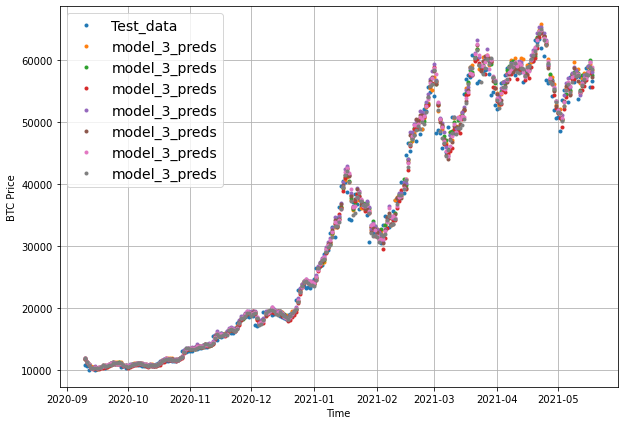

In [61]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

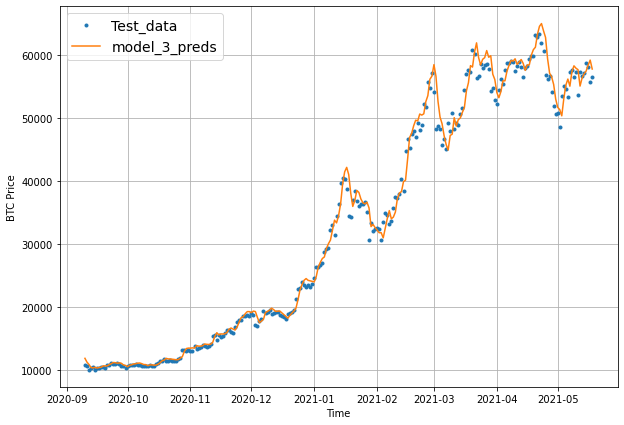

In [62]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), format="-", start=offset, label="model_3_preds")

### Which of our model is performing best so far?

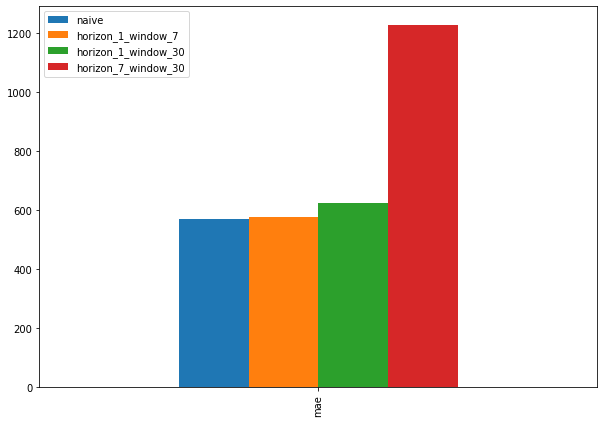

In [63]:
pd.DataFrame({"naive":naive_results["mae"],
              "horizon_1_window_7":model_1_results["mae"],
              "horizon_1_window_30":model_2_results["mae"],
              "horizon_7_window_30":model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

### Model 4: Conv1D

In [64]:
HORIZON = 1
WINDOW_SIZE = 7

In [65]:
# Create windowed dataset

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [66]:
# Create test/train splits

train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [67]:
# Check data sample shapes
train_windows[0].shape

(7,)

In [68]:
# Before we pass our data to conv1D, we have to reshape it to make sure it works

x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with Expanded shape:\n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with Expanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [69]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_Conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [70]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [71]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_Conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 7ms/step - loss: 566.8100


566.8099975585938

In [72]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:5]

18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8880.082, 8792.738, 9036.174, 8794.266, 8741.444], dtype=float32)>

In [73]:
# Evaluate predictions

model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 566.81,
 'mse': 1169908.2,
 'rmse': 1081.6229,
 'mape': 2.5353878,
 'mase': 0.9957282}

### Model 5: RNN (LSTM)

In [74]:
tf.random.set_seed(42)

# Let's an LSTM model with the functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# print(x.shape)
# x= layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# print(x.shape)
# Add another optional dense layer
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile the model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 7s 245ms/step - loss: 2506.9724 - val_loss: 11237.5693
Epoch 2/100
18/18 [==============================] - 4s 226ms/step - loss: 1028.6655 - val_loss: 1438.8740
Epoch 3/100
18/18 [==============================] - 2s 114ms/step - loss: 257.6387 - val_loss: 1027.5989
Epoch 4/100
18/18 [==============================] - 2s 95ms/step - loss: 196.5758 - val_loss: 1013.2790
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 183.7695 - val_loss: 1015.4737
Epoch 6/100
18/18 [==============================] - 2s 95ms/step - loss: 176.8616 - val_loss: 986.2106
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 172.4959 - val_loss: 1008.3422
Epoch 8/100
18/18 [==============================] - 2s 95ms/step - loss: 167.6578 - val_loss: 940.9050
Epoch 9/100
18/18 [==============================] - 2s 124ms/step - loss: 156.6377 - val_loss: 854.8196
Epoch 10/100
18/18 [==============================] -

In [75]:
# Load in the best version of model 5 and evaluate

model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 591.5799


591.5798950195312

In [78]:
# Make prediction with our LSTM model

model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8932.261, 8791.596, 8946.14 , 8774.206, 8746.522, 8747.686,
       8663.445, 8553.678, 8459.399, 8498.888], dtype=float32)>

In [80]:
# Evaluate model 5 preds

model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 591.57996,
 'mse': 1253226.0,
 'rmse': 1119.4757,
 'mape': 2.672617,
 'mase': 1.0392421}

### Make a multivariate time series

In [81]:
# Lets make a multivariate time series

bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [82]:
# Block reward values

block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

# Block reward dates

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [83]:
# Get datetime indexes for when to add in different block dates

block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [86]:
# Add block reward column

bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block reward column

bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days: block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


<AxesSubplot:xlabel='Date'>

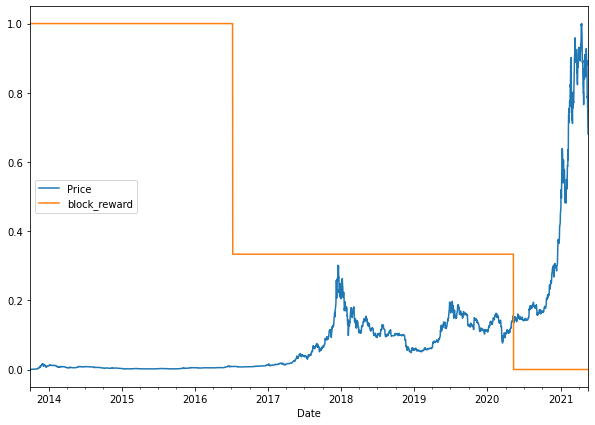

In [87]:
# Plot the block reward/price over time

from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))